# Creating a Deep Model to predict the antidepressant effect

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
PyTorch version 2.5.1
Numpy version 1.26.4
Pandas version 2.2.3


In [73]:
# Confirm device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
try: 
    name = torch.cuda.get_device_name(0)
    count = torch.cuda.device_count()
    print(f"Device count: {count}")
    print(f"Device name: {name}")
except RuntimeError:
    print('No GPUs detected')

Using cuda device
Device count: 1
Device name: NVIDIA L40S


In [ ]:
# Load the data
X_train = np.load('data/X_SYN.npy')
X_test = np.load('data/X_TEST_RAW.npy')

y_train = np.load('data/y_SYN.npy')
y_test = np.load('data/y_TEST_RAW.npy')


In [75]:
# Define the dataset
class COPEDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        cope_data = self.data[index]
        cope_data = (cope_data - np.min(cope_data)) / (np.max(cope_data) - np.min(cope_data))  # normalize

        label = self.target[index]
        volume = torch.tensor(cope_data, dtype=torch.float32).unsqueeze(0)  # (1, 91, 109, 91)
        label = torch.tensor([1.0, 0.0] if label == 0 else [0.0, 1.0], dtype=torch.float32)
        return volume, label

In [76]:
# Initiate the dataset and data loader
train_dataset = COPEDataset(X_train, y_train)
test_dataset = COPEDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=10)
test_dataloader = DataLoader(test_dataset)

In [77]:
# Define the model
class BrainClassifier3D(nn.Module):
    def __init__(self):
        super(BrainClassifier3D, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),   # volume (16, 45, 54, 45)
            nn.BatchNorm3d(16),
            nn.ReLU(),

            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),  # volume (32, 22, 26, 22)
            nn.BatchNorm3d(32),
            nn.ReLU(),

            # nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  #  (64, 12, 10, 12)
            # nn.BatchNorm3d(64),
            # nn.ReLU()
        )

        # Calculate the size of the flattened layer dynamically
        # We run a dummy tensor through the conv/pool layers to find the shape
        self._to_linear = None
        self._get_conv_output((1, 10, 7, 8)) # Dummy run to calculate self._to_linear


        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2),  # 2 output classes
            nn.Softmax()
        )

    def _get_conv_output(self, shape):
        """Helper function to calculate the input size for the fully connected layers."""
        # Create a dummy input tensor with batch size 1
        dummy_input = torch.rand(1, *shape) 
        output_features = self.conv_layers(dummy_input)
        # Store the calculated size
        self._to_linear = output_features.view(output_features.size(0), -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x  # logits


In [78]:
# Setup
model = BrainClassifier3D().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Train
for epoch in range(50):
    model.train()
    total_loss, correct = 0.0, 0

    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == torch.argmax(labels, dim=1)).sum().item()

    acc = correct / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}, Accuracy: {acc:.4f}")


Epoch 1, Loss: 2.80, Accuracy: 0.4054
Epoch 2, Loss: 2.71, Accuracy: 0.6216
Epoch 3, Loss: 2.67, Accuracy: 0.5946
Epoch 4, Loss: 2.63, Accuracy: 0.6757
Epoch 5, Loss: 2.57, Accuracy: 0.6486
Epoch 6, Loss: 2.56, Accuracy: 0.6486
Epoch 7, Loss: 2.53, Accuracy: 0.6757
Epoch 8, Loss: 2.48, Accuracy: 0.7297
Epoch 9, Loss: 2.45, Accuracy: 0.7297
Epoch 10, Loss: 2.45, Accuracy: 0.7838
Epoch 11, Loss: 2.39, Accuracy: 0.7568
Epoch 12, Loss: 2.35, Accuracy: 0.8378
Epoch 13, Loss: 2.32, Accuracy: 0.8108
Epoch 14, Loss: 2.30, Accuracy: 0.8108
Epoch 15, Loss: 2.25, Accuracy: 0.8378
Epoch 16, Loss: 2.25, Accuracy: 0.8378
Epoch 17, Loss: 2.21, Accuracy: 0.8649
Epoch 18, Loss: 2.15, Accuracy: 0.9189
Epoch 19, Loss: 2.17, Accuracy: 0.8649
Epoch 20, Loss: 2.09, Accuracy: 0.8649
Epoch 21, Loss: 2.06, Accuracy: 0.9189
Epoch 22, Loss: 1.99, Accuracy: 0.9189
Epoch 23, Loss: 1.97, Accuracy: 0.9459
Epoch 24, Loss: 1.98, Accuracy: 0.9189
Epoch 25, Loss: 1.92, Accuracy: 0.9459
Epoch 26, Loss: 1.88, Accuracy: 0.

In [79]:
# Test the model

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    preds_list = np.array([])
    actual_list = np.array([])
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            preds_list = np.append(preds_list, preds.item())
            actual_list = np.append(actual_list, torch.argmax(labels, dim=1).item())
            print(f'Predicted: {preds.item()}   True: {torch.argmax(labels, dim=1).item()}')
            correct += (preds == torch.argmax(labels, dim=1)).sum().item()
    return correct / len(dataloader.dataset), preds_list, actual_list

val_acc, preds_list, actual_list = evaluate(model, test_dataloader)
print(f"Validation Accuracy: {val_acc:.4f}")




Predicted: 0   True: 1
Predicted: 1   True: 1
Validation Accuracy: 0.5000


Text(0.5, 1.0, 'Predictive Results')

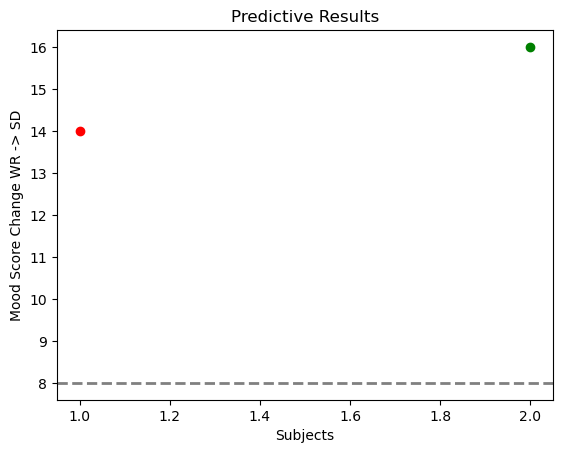

In [80]:
reg_vals = np.load('data/y_TEST_RAW_REG.npy')
thresh = 8

for i in range(len(reg_vals)):
    if preds_list[i] == 0:
        plt.plot((i+1), reg_vals[i], 'o', color='red')
    else:
        plt.plot((i+1), reg_vals[i], 'o', color='green')

plt.axhline(y=thresh, color='grey', linestyle='--', linewidth=2, label=f'Threshold at y={thresh}')

# Add labels and title
plt.xlabel("Subjects")
plt.ylabel("Mood Score Change WR -> SD")
plt.title("Predictive Results")